# Scraping

In [42]:
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select

from bs4 import BeautifulSoup
import requests
import time
import datetime as dt 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import os
import sys
import warnings

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
pd.options.display.max_columns=200


headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}


from selenium.webdriver.edge.options import Options

edge_options = Options()
#edge_options.add_argument('--headless')
edge_options.add_argument("--blink-settings=imagesEnabled=false")  # Disable images

driver = webdriver.Edge(options=edge_options)
driver.maximize_window()

In [43]:
path=r"C:\Users\berid\python\carsforsale project"

In [44]:
url="https://www.cars.com/shopping/results/?list_price_max=45000&makes[]=&maximum_distance=all&models[]=&page=1&page_size=100&stock_type=used&zip="
driver.get(url)

In [ ]:
all_urls=[]

page=0

while True:
    url_elements=WebDriverWait(driver,10).until(expected_conditions.visibility_of_all_elements_located((By.CSS_SELECTOR,'div[class="vehicle-card"]')))

    for url_element in url_elements:
        url=url_element.find_element(By.CSS_SELECTOR,'a').get_attribute('href')
        all_urls.append(url)

    try:
        next_page=driver.find_element(By.CSS_SELECTOR,'spark-button[aria-label="Next page"][data-scroll-behavior="auto"]')
        driver.execute_script('arguments[0].scrollIntoView();',next_page)
        driver.execute_script('arguments[0].click();',next_page)
        time.sleep(3)
    except Exception as e:
        print(e)
        break
    page+=1
    print(page,end='\r')


In [45]:
#pickle.dump(all_urls,open('all_urls.pickle','wb'))
all_urls=pickle.load(open('all_urls.pickle','rb'))

In [46]:
all_urls=list(set(all_urls))
len(all_urls)

9818

In [47]:
#concatenate all scraped data
scraped=[]
for file in os.listdir(os.path.join(path,'scraped_data')):
    file_path=os.path.join(path,'scraped_data',file)
    index=int(file.split('_')[-1].split('.pickle')[0])
    data=pickle.load(open(file_path,'rb'))
    if index!=0:
        os.remove(file_path)
    scraped.extend(data)

#remove duplicated data and save
unique_list = []
seen = set()
for dict_item in scraped:
    url = dict_item.get('Car URL', None)
    if url not in seen:
        seen.add(url)
        unique_list.append(dict_item)

pickle.dump(unique_list, open(os.path.join(path,'scraped_data',f'all_data_0.pickle'),'wb'))


#number of urls scraped and left to be scraped
scraped_urls=[i.get('Car URL',None) for i in unique_list]
scraped_urls=list(set(scraped_urls))

left=[i for i in all_urls if i not in scraped_urls]

print(f'Scraped : {len(scraped_urls)}')
print(f'Left : {len(left)}')

Scraped : 9818
Left : 0


In [48]:
def return_info_dict(car_url):

    driver.get(car_url)

    try:
        general_info=driver.find_element(By.CSS_SELECTOR,'div[class="title-section"]').text
    except:
        general_info=None

    try:
        price_info=driver.find_element(By.CSS_SELECTOR,'div[class="price-section "] span[class="primary-price"]').text
    except:
        price_info=None

    try:
        labels=driver.find_elements(By.CSS_SELECTOR,'div[class="basics-content-wrapper"] dl[class="fancy-description-list"] dt')
        values=driver.find_elements(By.CSS_SELECTOR,'div[class="basics-content-wrapper"] dl[class="fancy-description-list"] dd')
        basics_dict={}
        for label, value in zip(labels,values):
            try:
                label_text=label.text
                value_text=value.text
                basics_dict[label_text]=value_text
            except:
                continue
    except:
        basics_dict=None

    try:
        sellers_info=driver.find_element(By.CSS_SELECTOR,'section[class="sds-page-section seller-info"]').text
    except:
        sellers_info=None

    try:
        ratings_info=driver.find_element(By.CSS_SELECTOR,'div[class*="vehicle-reviews"]').text
    except:
        ratings_info=None

    info_dict={'Car URL':car_url,'General Info':general_info,'Price Info':price_info, 'Basics Dict':basics_dict, 'Sellers Info':sellers_info, 'Ratings Info':ratings_info}
    return info_dict

In [7]:
all_data=[]
for i, car_url in enumerate(left,start=1):

    try:
        info_dict=return_info_dict(car_url)
        all_data.append(info_dict)
    except Exception as e:
        print(e)
        continue
    
    if i%100==0 or i==len(left):
        pickle.dump(all_data, open(os.path.join(path,'scraped_data',f'all_data_{i}.pickle'),'wb'))
        all_data=[]
    
    print(f'{i}/{len(left)}',end='\r')


driver.quit()

In [49]:
all_data=[]

for file in os.listdir(os.path.join(path,'scraped_data')):
    file_path=os.path.join(path,'scraped_data',file)
    data=pickle.load(open(file_path,'rb'))
    all_data.extend(data)

df=pd.DataFrame(all_data)
df=df.drop_duplicates(subset='Car URL')

In [50]:
df.to_csv('used_cars_prices (raw).csv',index=False)
#df=pd.read_csv("used_cars_prices (raw).csv")

# Data Cleaning

In [51]:
df=df[df['General Info'].notna()]

In [52]:
manufacturer=df['General Info'].apply(lambda x:x.split('\n')[1].split(' ')[1].strip() if isinstance(x,str) else x)
year=df['General Info'].apply(lambda x:x.split('\n')[1].split(' ')[0].strip()if isinstance(x,str) else x).apply(pd.to_numeric,errors='coerce')
model=df['General Info'].apply(lambda x:' '.join(x.split('\n')[1].split(' ')[2:]) if isinstance(x,str) else x)

df.insert(df.columns.get_loc('General Info')+1,'Manufacturer',manufacturer)
df.insert(df.columns.get_loc('General Info')+2,'Model',model)
df.insert(df.columns.get_loc('General Info')+3,'Year',year)

df=df.drop(columns='General Info')

In [53]:
price_usd=df['Price Info'].apply(lambda x:x.replace('$','').replace(',','') if isinstance(x,str) else x).apply(pd.to_numeric,errors='coerce')
df.insert(df.columns.get_loc('Price Info')+1,'Price (USD)',price_usd)
df=df.drop(columns='Price Info')

### Basics DF

In [54]:
basics_df=pd.json_normalize(df['Basics Dict'])

basics_df=basics_df.drop(columns=['VIN','Stock #','Entertainment'])
nan_columns=basics_df.isna().mean()[basics_df.isna().mean()>0.4].index
basics_df=basics_df.drop(columns=nan_columns)

In [55]:
basics_df=basics_df.replace('–',None).replace('Yes',1).replace('No',0)

In [56]:
mpg_min=basics_df['MPG'].str.split('–').str[0].apply(pd.to_numeric,errors='coerce')
mpg_max=basics_df['MPG'].str.split('–').str[-1].apply(pd.to_numeric,errors='coerce')

basics_df.insert(basics_df.columns.get_loc('MPG')+1,'MPG MIN',mpg_min)
basics_df.insert(basics_df.columns.get_loc('MPG')+2,'MPG MAX',mpg_max)

basics_df=basics_df.drop(columns='MPG')

In [57]:
basics_df['Engine']=basics_df['Engine'].apply(lambda x:x.split('L')[0].split(' ')[-1] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')
basics_df=basics_df.rename(columns={'Engine':'Engine Volume (L)'})

In [58]:
basics_df['Mileage']=basics_df['Mileage'].apply(lambda x:x.split(' ')[0].replace(',','') if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')

In [59]:
basics_df['Accidents or damage']=basics_df['Accidents or damage'].apply(lambda x:0 if x=="None reported" else 1 if isinstance(x,str) else None)

In [60]:
drivetrain_dict={
    'All-wheel Drive':'AWD',
    'Front-wheel Drive':'FWD',
    'Four-wheel Drive':'AWD',
    'Rear-wheel Drive':'RWD',
    'Unknown':None
    }
basics_df['Drivetrain']=basics_df['Drivetrain'].map(drivetrain_dict)

In [61]:
basics_df['Fuel type'].unique()

array(['Gasoline', 'Hybrid', None, nan, 'E85 Flex Fuel', 'Diesel',
       'Gasoline / Natural Gas', 'Plug-In Hybrid', 'Other',
       'Diesel fuel type', 'Compressed Natural Gas', 'Gasoline fuel type'],
      dtype=object)

In [62]:
for col in ['Convenience','Safety','Exterior']:
    split_df = basics_df[col].str.split('\n', expand=True)
    dummy_df = pd.get_dummies(split_df.stack()).groupby(level=0).max().replace({True:1,False:0})
    dummy_df.reindex(basics_df.index, fill_value=0)

    basics_df=basics_df.drop(columns=col)
    basics_df=pd.concat([basics_df,dummy_df],axis=1)

In [63]:
basics_df['Transmission']=basics_df['Transmission'].apply(lambda x:
                                'Automatic' if 'automatic' in str(x).lower() or 'A/T' in str(x) else
                                'Manual' if 'manual' in str(x).lower() or 'M/T' in str(x) else 
                                'CVT' if 'cvt' in str(x).lower() else None
                                )

In [64]:
basics_df.select_dtypes(object).nunique()
basics_df=basics_df.drop(columns=['Exterior color','Interior color'])

In [65]:
basics_df=basics_df.reset_index(drop=True)

for col in basics_df.select_dtypes(object):
    dummies=pd.get_dummies(basics_df[col],prefix=col,dummy_na=False).astype(int)
    basics_df=basics_df.drop(columns=col)
    basics_df=pd.concat([basics_df,dummies],axis=1)

In [66]:
df=df.reset_index(drop=True)

col_index=df.columns.get_loc('Basics Dict')

df=pd.concat([
    df.iloc[:,:col_index],
    basics_df,
    df.iloc[:,col_index:]
],axis=1)

df=df.drop(columns='Basics Dict')

### Sellers Ratings

In [67]:
seller_rating=df['Sellers Info'].apply(lambda x:x.split('\n(')[0].split('\n')[-1] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')
seller_reviews_count=df['Sellers Info'].apply(lambda x:x.split('review')[0].split('(')[-1] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')

df.insert(df.columns.get_loc('Sellers Info')+1,'Seller Rating',seller_rating)
df.insert(df.columns.get_loc('Sellers Info')+2,'Seller Reviews Count',seller_reviews_count)
df=df.drop(columns='Sellers Info')

### Car Ratings

In [68]:
df['Ratings Info']=df['Ratings Info'].apply(lambda x:x.split('\nMost recent')[0] if isinstance(x,str) else None)

In [69]:
car_reviews_count=df['Ratings Info'].apply(lambda x:x.split('reviews)\n')[0].split('\n(')[-1] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')
car_rating=df['Ratings Info'].apply(lambda x:x.split('reviews)\n')[0].split('\n(')[0].split('\n')[-1] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')
recommendation_rate=df['Ratings Info'].apply(lambda x:x.split('reviews)\n')[-1].split('%')[0] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')

comfort_rating=df['Ratings Info'].apply(lambda x:x.split('Rating breakdown')[-1].split('Comfort\n')[-1].split('\n')[0] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')
interior_rating=df['Ratings Info'].apply(lambda x:x.split('Rating breakdown')[-1].split('Interior\n')[-1].split('\n')[0] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')
performance_rating=df['Ratings Info'].apply(lambda x:x.split('Rating breakdown')[-1].split('Performance\n')[-1].split('\n')[0] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')
value_rating=df['Ratings Info'].apply(lambda x:x.split('Rating breakdown')[-1].split('Value\n')[-1].split('\n')[0] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')
exterior_rating=df['Ratings Info'].apply(lambda x:x.split('Rating breakdown')[-1].split('Exterior\n')[-1].split('\n')[0] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')
reliability_rating=df['Ratings Info'].apply(lambda x:x.split('Rating breakdown')[-1].split('Reliability\n')[-1].split('\n')[0] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')

df.insert(df.columns.get_loc('Ratings Info')+1, 'Car Rating', car_rating)
df.insert(df.columns.get_loc('Ratings Info')+2, 'Car Reviews Count', car_reviews_count)
df.insert(df.columns.get_loc('Ratings Info')+3, 'Car Recommendation Rate', recommendation_rate)

df.insert(df.columns.get_loc('Ratings Info')+4, 'Car Comfort Rating', comfort_rating)
df.insert(df.columns.get_loc('Ratings Info')+5, 'Car Interior Rating', interior_rating)
df.insert(df.columns.get_loc('Ratings Info')+6, 'Car Performance Rating', performance_rating)
df.insert(df.columns.get_loc('Ratings Info')+7, 'Car Value Rating', value_rating)
df.insert(df.columns.get_loc('Ratings Info')+8, 'Car Exterior Rating', exterior_rating)
df.insert(df.columns.get_loc('Ratings Info')+9, 'Car Reliability Rating', reliability_rating)

df=df.drop(columns='Ratings Info')

In [70]:
df.select_dtypes(object).nunique()

Car URL         8853
Manufacturer      56
Model           3120
dtype: int64

In [29]:
df=df.drop(columns=['Car URL','Model'])

In [30]:
df.to_csv('used_cars_prices (cleaned).csv',index=False)
df=pd.read_csv("used_cars_prices (cleaned).csv")

# ML

In [31]:
df

,Manufacturer,Year,Price (USD),MPG MIN,MPG MAX,Engine Volume (L),Mileage,Accidents or damage,1-owner vehicle,Personal use only,Adaptive Cruise Control,Autopilot,Cooled Seats,Heated Seats,Heated Steering Wheel,Keyless Start,Navigation System,Power Liftgate,Remote Start,Automatic Emergency Braking,Backup Camera,Blind Spot Monitor,Brake Assist,LED Headlights,Lane Departure Warning,Rear Cross Traffic Alert,Stability Control,Alloy Wheels,Moonroof,Sunroof/Moonroof,Tow Hitch,Tow Hooks,Drivetrain_AWD,Drivetrain_FWD,Drivetrain_RWD,Fuel type_Compressed Natural Gas,Fuel type_Diesel,Fuel type_Diesel fuel type,Fuel type_E85 Flex Fuel,Fuel type_Gasoline,Fuel type_Gasoline / Natural Gas,Fuel type_Gasoline fuel type,Fuel type_Hybrid,Fuel type_Other,Fuel type_Plug-In Hybrid,Transmission_Automatic,Transmission_CVT,Transmission_Manual,Seating_Leather Seats,Seating_Leather Seats\nMemory Seat,Seating_Leather Seats\nMemory Seat\nThird Row Seating,Seating_Leather Seats\nThird Row Seating,Seating_Memory Seat,Seating_Memory Seat\nThird Row Seating,Seating_Third Row Seating,Seller Rating,Seller Reviews Count,Car Rating,Car Reviews Count,Car Recommendation Rate,Car Comfort Rating,Car Interior Rating,Car Performance Rating,Car Value Rating,Car Exterior Rating,Car Reliability Rating
0,Hyundai,2022,29691.0,NaN,NaN,2.5,36007,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,3.5,855.0,4.2,37.0,75.0,4.2,4.1,4.3,3.7,4.5,4.2
1,MINI,2016,9500.0,25.0,35.0,1.5,104753,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,3.2,17.0,4.8,12.0,91.0,4.8,4.7,4.9,4.6,4.9,4.7
2,Mitsubishi,2022,20999.0,25.0,26.0,1.5,60922,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,2.7,513.0,4.6,9.0,88.0,4.6,4.4,4.4,4.6,4.6,4.3
3,FIAT,2013,5999.0,31.0,34.0,1.4,78996,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,NaN,4.0,4.5,124.0,88.0,4.2,4.5,4.4,4.4,4.7,4.4
4,Jeep,2023,26304.0,23.0,29.0,1.3,1075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3.9,324.0,5.0,2.0,100.0,5.0,5.0,4.5,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8848,Toyota,2019,18473.0,27.0,31.0,2.0,50540,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,4.6,26.0,4.8,92.0,93.0,4.8,4.8,4.7,4.7,4.9,4.8
8849,Kia,2023,40999.0,36.0,33.0,1.6,3318,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,4.2,NaN,4.8,5.0,100.0,4.8,4.2,4.4,4.4,5.0,4.6
8850,Hyundai,2024,19600.0,32.0,41.0,NaN,9654,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.7,NaN,5.0,2.0,100.0,4.5,5.0,4.5,4.5,5.0,5.0
8851,BMW,2024,39495.0,NaN,NaN,NaN,15510,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3.0,356.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
for col in df.select_dtypes(object):
    dummies=pd.get_dummies(df[col],prefix=col,dummy_na=False).astype(int)
    df=df.drop(columns=col)
    df=pd.concat([df,dummies],axis=1)

In [33]:
df=df.dropna(subset='Price (USD)')

In [34]:
X=df.drop(columns='Price (USD)')
y=df['Price (USD)']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)

In [35]:
from xgboost import XGBRegressor
model=XGBRegressor()

In [36]:
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [37]:
train_prediction=model.predict(X_train)
test_prediction=model.predict(X_test)

In [38]:
from sklearn import metrics

r2_train=metrics.r2_score(train_prediction,y_train)
r2_test=metrics.r2_score(test_prediction,y_test)

mae_train=metrics.mean_absolute_error(train_prediction,y_train)
mae_test=metrics.mean_absolute_error(test_prediction,y_test)

rmse_train=metrics.mean_squared_error(train_prediction,y_train,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,y_test,squared=False)

train_scores={'R2_train':r2_train,'MAE_train':mae_train,'RMSE_train':rmse_train}
test_scores={'R2_test':r2_test,'MAE_test':mae_test,'RMSE_test':rmse_test}
print(train_scores)
print(test_scores)

{'R2_train': 0.9690792646629801, 'MAE_train': 1295.6467256535245, 'RMSE_train': 1713.8523716392106}
{'R2_test': 0.8453646913043333, 'MAE_test': 2722.3699117151104, 'RMSE_test': 3736.7390973516012}


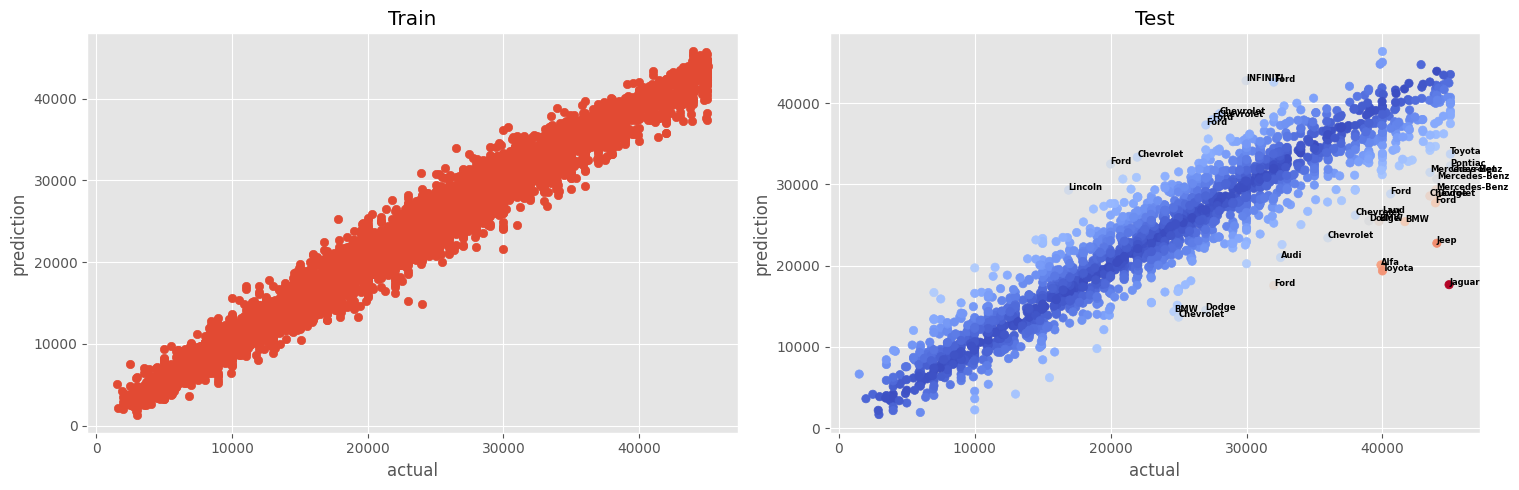

In [39]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(y_train,train_prediction)
ax1.set_xlabel('actual')
ax1.set_ylabel('prediction')
ax1.set_title('Train')
ax2.scatter(y_test,test_prediction,c=(y_test-test_prediction).abs(),cmap='coolwarm')
ax2.set_xlabel('actual')
ax2.set_ylabel('prediction')
ax2.set_title('Test')

plt.tight_layout()

brands=X_test[X_test.columns[X_test.columns.str.contains('Manufacturer_')]].idxmax(axis=1).str.replace('Manufacturer_','')
absolute_error=(y_test-test_prediction).abs()
#plot text
for error,actual,prediction,brand in zip(absolute_error,y_test,test_prediction,brands):
    if error<mae_test-2*rmse_test or error>mae_test+2*rmse_test:
        ax2.text(actual,prediction,brand,fontweight='bold',size=6)
    
plt.show()

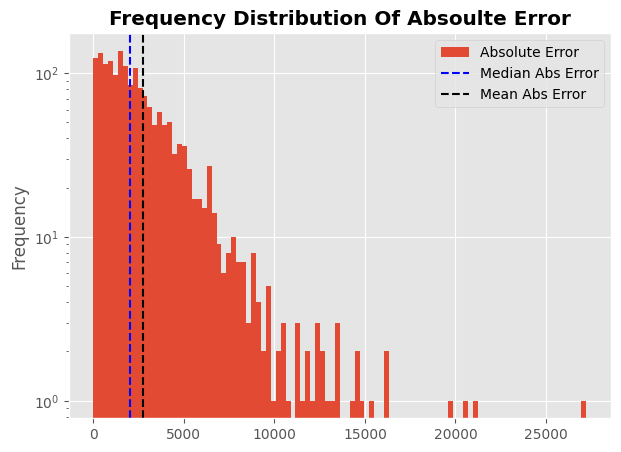

In [40]:
absolute_error=(y_test-test_prediction).abs()


fig,ax=plt.subplots(figsize=(7,5))
absolute_error.plot.hist(ax=ax,bins=100,label='Absolute Error')
ax.set_title('Frequency Distribution Of Absoulte Error',fontweight='bold')
median_abs_error=absolute_error.median()
ax.axvline(median_abs_error,label='Median Abs Error',color='blue',ls='--')
ax.axvline(mae_test,label='Mean Abs Error',color='black',ls='--')
ax.legend()
ax.set_yscale('log')
plt.show()

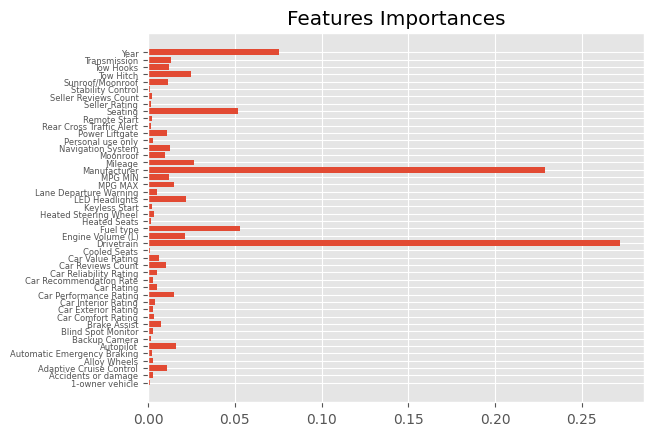

In [41]:
feature_names=model.feature_names_in_
weights=model.feature_importances_

weights_df=pd.DataFrame({'feature_names':feature_names,'weights':weights})
weights_df_grouped=weights_df.groupby(weights_df['feature_names'].str.split('_').str[0])['weights'].sum()

plt.barh(y=weights_df_grouped.index,width=weights_df_grouped.values)
plt.yticks(size=6)
plt.title('Features Importances')
plt.show()